## Test uniform 

Processing iteration 1
Processing iteration 101
Processing iteration 201
Processing iteration 301
Processing iteration 401
Processing iteration 501
Processing iteration 601
Processing iteration 701
Processing iteration 801
Processing iteration 901


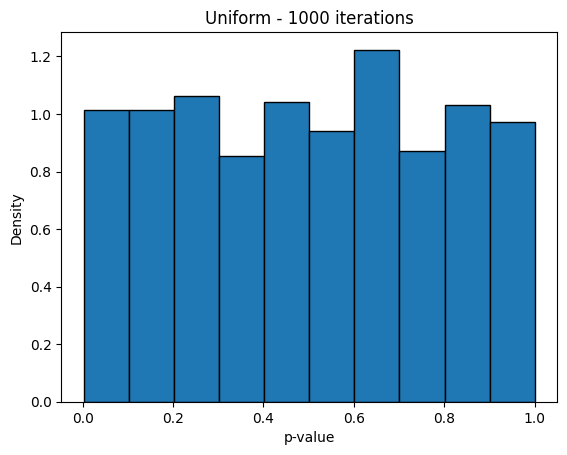

In [13]:
import numpy as np
from sklearn.linear_model import Lasso
import utils
from CoRT_builder import CoRT
import importlib
import matplotlib.pyplot as plt
import oc
importlib.reload(utils)
importlib.reload(oc)

n_target = 50
n_source = 20
p = 100
K = 10
Ka = 8
h = 30
lamda = 0.1
s_vector = [0] * 5
T = 5
s = len(s_vector)
CoRT_model = CoRT(alpha=lamda)
p_values = []
alpha = 0.05
iteration = 1000

CoRT_model = CoRT(alpha=lamda)

for iter in range(iteration):
  if (iter%100==0):
    print(f"Processing iteration {iter+1}")

  target_data, source_data = CoRT_model.gen_data(n_target, n_source, p, K, Ka, h, s_vector, s, "AR")
  similar_source_index = CoRT_model.find_similar_source(n_target, K, target_data, source_data, T=T, verbose=False)

  X_combined, y_combined = CoRT_model.prepare_CoRT_data(similar_source_index, source_data, target_data)

  model = Lasso(alpha=lamda, fit_intercept=False, random_state=42)
  model.fit(X_combined, y_combined.ravel())
  beta_hat_target = model.coef_[-p:]

  active_indices = np.array([i for i, b in enumerate(beta_hat_target) if b != 0])

  if len(active_indices) == 0:
      # print(f"Iteration {iter}: Lasso selected no features. Skipping.")
      continue

  j = np.random.choice(len(active_indices))
  selected_feature_index = active_indices[j]

  X_target = target_data["X"]
  y_target = target_data["y"]
  X_active, X_inactive = utils.get_active_X(beta_hat_target, X_target)
  etaj, etajTy = utils.construct_test_statistic(y_target, j, X_active)

  Sigma = np.eye(n_target)
  b_global = Sigma @ etaj @ np.linalg.pinv(etaj.T @ Sigma @ etaj)
  a_global = (np.eye(n_target) - b_global @ etaj.T) @ y_target

  folds = utils.split_target(T, X_target, y_target, n_target)

  L_train, R_train = oc.get_Z_train(etajTy, folds, source_data, a_global, b_global, lamda, K, T)
  L_val, R_val = oc.get_Z_val(folds, T, K, a_global, b_global, etajTy, lamda, source_data)
  L_CoRT, R_CoRT, Az = oc.get_Z_CoRT(X_combined, similar_source_index, lamda, a_global, b_global, source_data, etajTy)

  L_final, R_final = oc.combine_Z(L_train, R_train, L_val, R_val, L_CoRT, R_CoRT)

  etaT_sigma_eta = (etaj.T @ Sigma @ etaj).item()
  sigma_z = np.sqrt(etaT_sigma_eta)
  truncated_cdf = utils.computed_truncated_cdf(L_final, R_final, etajTy, 0, sigma_z)
  p_value = 2 * min(truncated_cdf, 1 - truncated_cdf)
  p_values.append(p_value)

plt.hist(p_values, bins=10, edgecolor='black', density=True)
plt.title(f"Uniform - {iteration} iterations")
plt.xlabel("p-value")
plt.ylabel("Density")
plt.show()

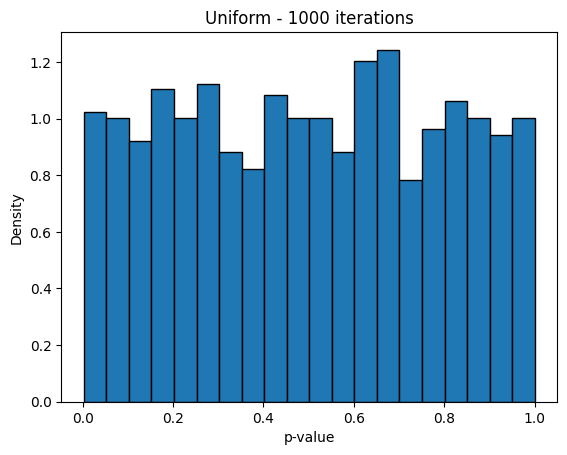

In [14]:
plt.hist(p_values, bins=20, edgecolor='black', density=True)
plt.title(f"Uniform - {iteration} iterations")
plt.xlabel("p-value")
plt.ylabel("Density")
plt.show()

## Test FPR TPR

In [16]:
import numpy as np
from sklearn.linear_model import Lasso
import utils
from CoRT_builder import CoRT
import importlib
import matplotlib.pyplot as plt
import oc
importlib.reload(utils)
importlib.reload(oc)

n_target = 50
n_source = 20
p = 100
K = 10
Ka = 8
h = 30
lamda = 0.1
s_vector = [0] * 5
T = 5
s = len(s_vector)
CoRT_model = CoRT(alpha=lamda)
results_storage = []
alpha = 0.05
iteration = 1000

CoRT_model = CoRT(alpha=lamda)

for iter in range(iteration):
  if (iter%100==0):
    print(f"Processing iteration {iter+1}")

  target_data, source_data = CoRT_model.gen_data(n_target, n_source, p, K, Ka, h, s_vector, s, "AR")
  similar_source_index = CoRT_model.find_similar_source(n_target, K, target_data, source_data, T=T, verbose=False)

  X_combined, y_combined = CoRT_model.prepare_CoRT_data(similar_source_index, source_data, target_data)

  model = Lasso(alpha=lamda, fit_intercept=False, random_state=42)
  model.fit(X_combined, y_combined.ravel())
  beta_hat_target = model.coef_[-p:]

  active_indices = np.array([i for i, b in enumerate(beta_hat_target) if b != 0])

  if len(active_indices) == 0:
      print(f"Iteration {iter}: Lasso selected no features. Skipping.")
      continue

  j = np.random.choice(len(active_indices))
  selected_feature_index = active_indices[j]

  X_target = target_data["X"]
  y_target = target_data["y"]
  X_active, X_inactive = utils.get_active_X(beta_hat_target, X_target)
  etaj, etajTy = utils.construct_test_statistic(y_target, j, X_active)

  Sigma = np.eye(n_target)
  b_global = Sigma @ etaj @ np.linalg.pinv(etaj.T @ Sigma @ etaj)
  a_global = (np.eye(n_target) - b_global @ etaj.T) @ y_target

  folds = utils.split_target(T, X_target, y_target, n_target)

  L_train, R_train = oc.get_Z_train(etajTy, folds, source_data, a_global, b_global, lamda, K, T)
  L_val, R_val = oc.get_Z_val(folds, T, K, a_global, b_global, etajTy, lamda, source_data)
  L_CoRT, R_CoRT, Az = oc.get_Z_CoRT(X_combined, similar_source_index, lamda, a_global, b_global, source_data, etajTy)

  L_final, R_final = oc.combine_Z(L_train, R_train, L_val, R_val, L_CoRT, R_CoRT)

  etaT_sigma_eta = (etaj.T @ Sigma @ etaj).item()
  sigma_z = np.sqrt(etaT_sigma_eta)
  truncated_cdf = utils.computed_truncated_cdf(L_final, R_final, etajTy, 0, sigma_z)
  p_value = 2 * min(truncated_cdf, 1 - truncated_cdf)

  is_signal = (selected_feature_index < s) 
  results_storage.append({
        "p_value": p_value,
        "is_signal": is_signal,
        "feature_idx": selected_feature_index
  })

is_signal_cases = [r for r in results_storage if r['is_signal']]
not_signal_cases = [r for r in results_storage if not r['is_signal']]

false_positives = sum(1 for c in not_signal_cases if c['p_value'] <= alpha)
fpr = false_positives / len(not_signal_cases)
print(f"FPR: {fpr:.4f} (Target: {alpha})")

true_positives = sum(1 for r in is_signal_cases if r['p_value'] <= alpha)
tpr = true_positives / len(is_signal_cases)
print(f"TPR: {tpr:.4f}")

Processing iteration 1
Processing iteration 101
Processing iteration 201
Processing iteration 301
Processing iteration 401
Processing iteration 501
Processing iteration 601
Processing iteration 701
Processing iteration 801
Processing iteration 901
FPR: 0.0370 (Target: 0.05)
TPR: 0.0566
